In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

Load the dataset for training and testing and add a dataloader around the datasets.

In [5]:
transform = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ]
)

batch_size = 4 
num_workers = 2

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


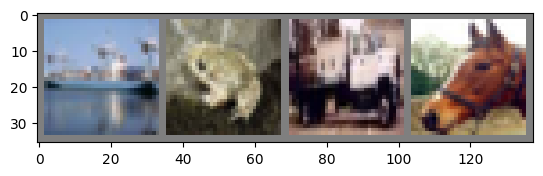

ship  frog  truck horse


In [12]:
import matplotlib.pyplot as plt 
import numpy as np 

def imshow(img):
    img = img / 2 + 0.5 # unnormalize pixel values
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [17]:
import torch.nn as nn 
import torch.nn.functional as F

Now lets create the CNN consisting of alternating layers of convolutional and pooling layers followed by fully connected (fc) layers. 

In [24]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5) # first convolutional layer (3 input channels for rgb images), 6 output channels (i.e. filters), kernel size 5x5) 
        # why 6 output channels?
        self.pool = nn.MaxPool2d(2,2) # max pooling kernel size of 2x2 and stride of 2 reducing input dimensions by factor 2
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120) # fully connected layer
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x))) # relu activation: f(x)=max(0,x)
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 
    
net = Net()



Create a summary plot and let us try to understand the output dimensions between each layer. The output size for each dimension of a convoluational layer calculates as:
```
output_size = (input_size - kernel_size + 2*padding) / stride + 1
```
which reduces with padding=0 and stride=0 to
```
output_size = (input_size - kernel_size) + 1
```
I.e. for the first convolutional layer, when we insert an image of size 32x32 with 3 channels (rgb) gives:
```
output_height = (32 - 5) + 1 = 28
output_width = (32 - 5) + 1 = 28
```
With six channels/filters we get as ouptut 6x28x28
Then the pooling reduces the dimensions (width and height) by a factor of 2 but preserves its features, giving 6x14x14. Then again a conv. layer:
```
output_height = (14 - 5) + 1 = 10
output_width = (14 - 5) + 1 = 10
```
giving 16x10x10 (we have there 16 output channels) as size of the feature map (output of a conv. layer). Again, pooling leads then to 16x5x5 as output shape. Thats then inserted into fully connected layers:
```
16x5x5 -> 120 -> 84 -> 10
```
and the final output, 10, is the number of classes/labels.

# Display the architecture summary

the dummy image has to be of the form (3,32,32) in order to get the correct dimensions for self.fc1 = nn.Linear(16*5*5,120) after hte conv and pooling layers

In [32]:
from torchsummary import summary
summary(net, (3, 32, 32))  




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


Loss function and optimizer:
- loss: cross-entropy as loss function measuring the different between prediction and target
- optimizer: algorithm to optimize the weights, we use stochastic gradient descend (SGD)

In [37]:
import torch.optim as optim 
learning_rate = 0.001

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9) 

Let us implement the training loop. In the training, we iteratre multiple times over the training data set, defined by the n_epochs parameter. 

In [38]:
n_epochs = 2 

for epoch in range(2):
    running_loss = 0.0 
    for i,data in enumerate(trainloader, 0):
        inputs, labels = data 

        optimizer.zero_grad() # zero parameter gradients 
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() 

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')




[1,  2000] loss: 2.196
[1,  4000] loss: 1.837
[1,  6000] loss: 1.673
[1,  8000] loss: 1.578
[1, 10000] loss: 1.500
[1, 12000] loss: 1.452
[2,  2000] loss: 1.387
[2,  4000] loss: 1.354
[2,  6000] loss: 1.326
[2,  8000] loss: 1.345
[2, 10000] loss: 1.297
[2, 12000] loss: 1.283
Finished Training


Save the model. 

In [39]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Now it comes the testing step. First some displaying.

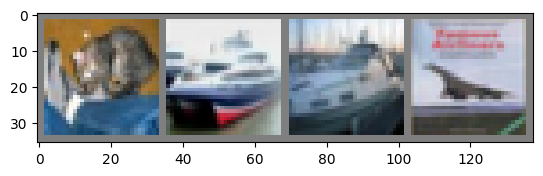

GroundTruth:  cat   ship  ship  plane


In [40]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


Load the net back from disk.

In [41]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Get our predictions.

In [43]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


Now check the performance for the full dataset.

In [46]:
correct = 0 
total = 0 


with torch.no_grad():
    for data in testloader: 
        images, labels = data 
        outputs = net(images)
        _, prediced = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 9 %


In [47]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 61.1 %
Accuracy for class: car   is 57.6 %
Accuracy for class: bird  is 36.5 %
Accuracy for class: cat   is 21.0 %
Accuracy for class: deer  is 38.7 %
Accuracy for class: dog   is 52.4 %
Accuracy for class: frog  is 57.9 %
Accuracy for class: horse is 70.5 %
Accuracy for class: ship  is 80.2 %
Accuracy for class: truck is 58.9 %
